In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path

import numpy as np
import pandas as pd
import salem
import xarray as xr

import pystream as pst

from src import paths

In [3]:
dem_fp = path.join(paths.processed_data_path, 'filled_dem.tif')
cropf_fp = path.join(paths.processed_data_path, 'crop_factor.tif')
whc_fp = path.join(paths.processed_data_path, 'aligned_whc.tif')

### Select the range of years in which we want to simulate 

In [4]:
years = range(2000, 2003)  # note that this does not include the end year

## Climatological data

### Load the cropped datasets, only for the years of interest 

This way we avoid aligning temporal snapshots that we will not use later

In [5]:
prec_ds = xr.open_dataset(
    path.join(paths.processed_data_path, 'cropped_prec.nc'), decode_times=False)
temp_ds = xr.open_dataset(
    path.join(paths.processed_data_path, 'cropped_temp.nc'), decode_times=False)

n = len(years)  # number of years

first_month = (years[0] - 1900) * 12  # time is 'months since 1900'
# unlike range, slices include both extremes, hence the `- 1` at the end
last_month = first_month + n * 12 - 1

prec_ds = prec_ds.sel(time=slice(first_month, last_month))
temp_ds = temp_ds.sel(time=slice(first_month, last_month))

### Use salem to align the datasets to a reference raster, i.e., the DEM

In [6]:
dem_ds = salem.open_xr_dataset(dem_fp)

prec_ds = dem_ds.salem.transform(prec_ds)
temp_ds = dem_ds.salem.transform(temp_ds)

## Load actual (observed) flow at the gauge 

In [7]:
obs_df = pd.read_csv(
    path.join(paths.external_data_path, 'watershed', 'discharge.csv'), index_col=0)
obs_df.head()

          1      2      3      4      5      6      7     8      9     10  \
1993   4.07   2.78   3.19   7.35   2.51   3.82   4.11  2.77   8.94  15.80   
1994  19.60   7.41   6.27  11.00  14.50   8.10   3.21  2.07  13.80   9.51   
1995  30.70  25.70  18.60   7.60  14.10  10.40   3.05  2.93  11.40   3.19   
1996  11.00   5.53   8.06   3.77   4.04   3.03   7.95  4.11   2.15   4.64   
1997   8.33  11.40   4.99   3.41   9.28   8.14  11.10  4.81   5.47   3.68   

         11    12  
1993   3.93  19.2  
1994   6.91  10.4  
1995   4.22  12.7  
1996  14.60  16.5  
1997   4.32  11.3  

In [8]:
# We are only interested on certain years

obs_df.loc[years[0]:years[-1]]

          1      2      3      4      5      6     7     8     9     10  \
2000   7.44  15.20  11.40   9.37   4.67   3.19  6.40  2.83  2.40   8.92   
2001  21.50   9.16  35.60  19.00   8.06  13.50  7.13  3.51  7.60   5.83   
2002   5.89  10.90   9.79   3.07  11.00   3.91  3.43  5.26  3.06  10.90   

         11     12  
2000  16.40   7.12  
2001   4.19   5.35  
2002  18.10  11.50  

In [9]:
# we will transform the observed data for our period into a time-series-like
# flat array to compare with the simulation later

obs_gauge_flow = np.concatenate([obs_df.loc[year].values for year in years])
obs_gauge_flow

array([ 7.44, 15.2 , 11.4 ,  9.37,  4.67,  3.19,  6.4 ,  2.83,  2.4 ,
        8.92, 16.4 ,  7.12, 21.5 ,  9.16, 35.6 , 19.  ,  8.06, 13.5 ,
        7.13,  3.51,  7.6 ,  5.83,  4.19,  5.35,  5.89, 10.9 ,  9.79,
        3.07, 11.  ,  3.91,  3.43,  5.26,  3.06, 10.9 , 18.1 , 11.5 ])

## Manual Calibration

The idea of the manual calibration is simple: we run our model with some
`parameters`, evaluate the result with some criteria, i.e., the
Nash-Sutcliffe coefficient, and tune the `parameters` until we get a good fit.

According to the literature, a good rainfall-runoff model should give a
Nash-Sutcliffe coefficient greater than 0.75.

Note that we exclude the first 6 months since the model's state variables
(i.e., snow accumulation, available water and ground water) start from zero.

In [10]:
# for Switzerland
monthly_daylight_hours = [9, 10, 12, 13.5, 15, 16, 15.5, 14.5, 12.5, 11, 9.5, 8.5]

In [11]:
parameters = {
    'TEMP_SNOW_FALL': 3, 'TEMP_SNOW_MELT': -2, 'SNOW_MELT_COEFF': 35,
    'CROPF_COEFF': 1.6, 'WHC_COEFF': 1.25, 'TOGW': .6, 'C': .45, 'HEAT_COEFF': .9
}

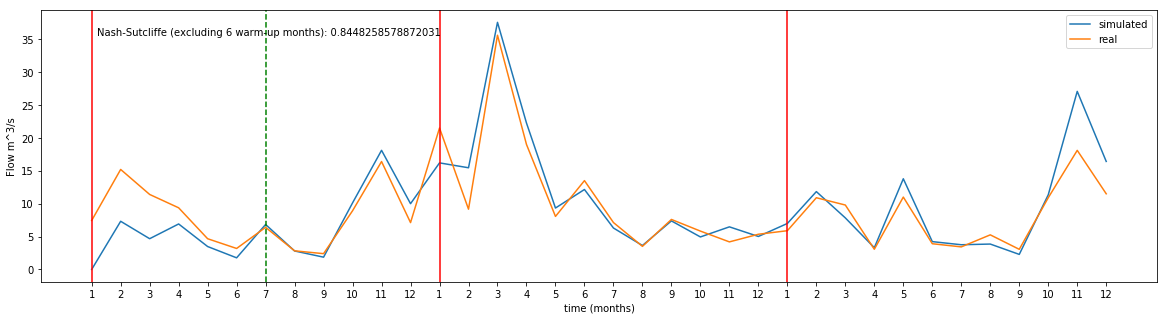

In [12]:
ms = pst.MonthlySimulation(
    dem_fp, cropf_fp, whc_fp, prec_ds, temp_ds,
    monthly_daylight_hours=monthly_daylight_hours, init_parameters=parameters)
ms.simulate()
ms.plot_gauge_flow(obs_gauge_flow, figsize=(20, 5), num_warmup_months=6)

The above seems good enough (of course I had already calibrated the model before)

## Validation

We will reload the climatological datasets, select another period of interest to
validate our calibration, align the datasets to our terrain data, run the model
again and compare the simulated flow with the observed flow for the validation
period of interest

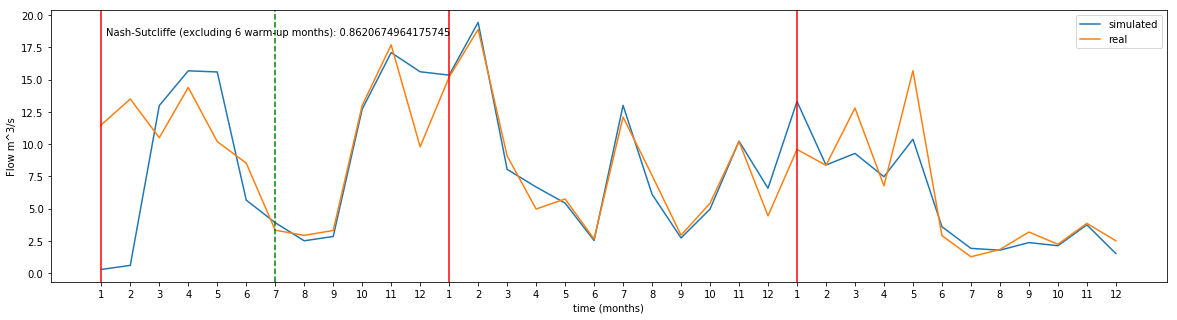

In [13]:
prec_ds = xr.open_dataset(
    path.join(paths.processed_data_path, 'cropped_prec.nc'), decode_times=False)
temp_ds = xr.open_dataset(
    path.join(paths.processed_data_path, 'cropped_temp.nc'), decode_times=False)

years = range(2013, 2016)
n = len(years)  # number of years

first_month = (years[0] - 1900) * 12  # time is 'months since 1900'
last_month = first_month + n * 12 - 1  # unlike range, slices include both extremes

prec_ds = prec_ds.sel(time=slice(first_month, last_month))
temp_ds = temp_ds.sel(time=slice(first_month, last_month))

dem_ds = salem.open_xr_dataset(dem_fp)

prec_ds = dem_ds.salem.transform(prec_ds)
temp_ds = dem_ds.salem.transform(temp_ds)

obs_gauge_flow = np.concatenate([obs_df.loc[year].values for year in years])

ms = pst.MonthlySimulation(
    dem_fp, cropf_fp, whc_fp, prec_ds, temp_ds,
    monthly_daylight_hours=monthly_daylight_hours, init_parameters=parameters)

ms.simulate()
ms.plot_gauge_flow(obs_gauge_flow, figsize=(20, 5))

Good to go!